In [1]:
import simpy
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import scipy.stats
import copy
import time
plt.style.use("seaborn")

In [2]:
class Gantt:
    def __init__(self):
        self.gantt_data = {"MC": [],
                           "Order" : [],
                           "Start time" : [],
                           "Process time" : []}

    def update_gantt(self, MC, ST, PT, job):
        self.gantt_data['MC'].append("M{}".format(MC))
        self.gantt_data['Order'].append(job)
        self.gantt_data['Start time'].append(ST)
        self.gantt_data['Process time'].append(PT)

    def draw_gantt(self, T_NOW, save_name = None):
        #set color list
        # fig = plt.figure(figsize=(12, 6))
        fig, axes = plt.subplots(1, 1, figsize=(16, 6))
        ax = axes
        colors = list(mcolors.CSS4_COLORS.keys())
        #draw gantt bar
        y = self.gantt_data['MC']
        width = self.gantt_data['Process time']
        left = self.gantt_data['Start time']
        color = [] 
        for j in self.gantt_data['Order']: 
            if j == None:
                color.append('black')
            else:
                color.append(colors[int(j)])

        # plt.barh(y = y, width = width, height = 0.5, color=color,left = left, align = 'center',alpha = 0.6)
        ax.barh(y     = y    , width     = width , height    = 0.5     ,\
                color = color, left      = left  , align     = 'center',\
                alpha = 0.6, edgecolor ='black', linewidth = 1)
        #add text
        for i in range(len(self.gantt_data['MC'])):
            text_x = self.gantt_data['Start time'][i] + self.gantt_data['Process time'][i]/2
            text_y = self.gantt_data['MC'][i]
            text = self.gantt_data['Order'][i]
            # plt.text(text_x, text_y, 'J'+str(text), verticalalignment='center', horizontalalignment='center', fontsize=8)
            if text != None:
                ax.text(text_x, text_y, 'J'+str(text), verticalalignment='center', horizontalalignment='center', fontsize=8)
        #figure setting
        ax.set_xlabel("time")
        ax.set_ylabel("Machine")
        ax.set_title("Gantt Chart")
        if T_NOW >= 20:
            ax.set_xticks(np.arange(0, T_NOW+1, 5))
        else:
            ax.set_xticks(np.arange(0, T_NOW+1, 1))
        # plt.grid(True)

        if save_name != None:
            plt.savefig(save_name)

        return fig

In [3]:
#columns=[ job_type, arrival_time, process_time, due_dates]
JOB_DATA = pd.read_csv('job_data.csv').to_numpy(dtype = np.int32)

#determine setup_time by job_type
SET_UP_TIME = pd.read_csv('setup_times.csv').to_numpy()

WEIGHTS = np.ones(len(JOB_DATA))

QUEUE_MAX_CONTENT = float('inf')

PROCESSORS_AVAILABLE = 4

ACTION_SPACES = 6  #[SPT,EDD,MST,ST,CR,WSPT]

In [4]:
class Product:
    def __init__(self, ID, j_type, arrival_time, process_time, due_dates):
        self.ID = ID
        self.type = j_type
        self.arrival_time = arrival_time
        self.process_time = process_time
        self.due_dates = due_dates
        self.finish_time = None
        
class Source:
    def __init__(self, name, factory):
        self.name = name
        self.factory = factory
        self.env = factory.env
        #output: the number of jobs arrival
        self.output = 0
        
    def initialization(self,output):
        self.queue = output
        self.process = self.env.process(self.generate_product())
             
    def generate_product(self):
        for i in range(len(JOB_DATA)):
            inter_arrival = JOB_DATA[i][1] - JOB_DATA[i-1][1] if i>=1 else JOB_DATA[i][1]
            
            yield self.env.timeout(inter_arrival)
            self.output += 1
            product = Product(i, JOB_DATA[i][0], JOB_DATA[i][1], JOB_DATA[i][2], JOB_DATA[i][3])
            if self.queue.is_queue_full() == True:
                self.factory.L_calculator.change(self.env, True)
                print("{} : product {} ,type{} arrive".format(self.env.now, product.ID, product.type))
                self.queue.product_arrival(product)
                
class Queue:
    def __init__(self, factory, max_content, name):
        self.name = name
        self.factory = factory
        self.env = factory.env
        self.queue = []
        self.max_content = max_content
        self.entity_type_now = np.zeros((PROCESSORS_AVAILABLE,), dtype=np.int32)
        
        
    
    def initialization(self,output):
        self.processors = output
        
        
    def is_queue_full(self):
        assert len(self.queue) <= self.max_content
        if len(self.queue) == self.max_content:
            return False
        elif len(self.queue) < self.max_content:
            return True
        
    def direct_process(self):
        if len(self.queue) == 1:
            for i in range(len(self.processors)):
                if self.processors[i].is_free == True:
                    product = self.queue[0]
                    self.factory.L_q_calculator.change(self.env, False)
                    self.entity_type_now[i] = product.type
                    self.queue.pop(0)
                    self.processors[i].process(product)
                    break
    
    def get_product(self, i):
        if len(self.queue) > 0:
            self.factory.decision_point.succeed()
            self.factory.decision_point = self.env.event()
            self.env.process(self.wait_for_action(i))
            
    def wait_for_action(self, i):
        yield self.factory.get_action
        if len(self.queue) > 0:
            self.sort_queue(self.factory.dispatcher.action, i)
            product = self.queue[0]
            self.queue.pop(0)
            self.factory.L_q_calculator.change(self.env, False)
            self.entity_type_now[i] = product.type
            self.processors[i].process(product)
            
    
    def product_arrival(self, product):
        self.factory.L_q_calculator.change(self.env, True)
        self.queue.append(product)
        self.direct_process()
        
        
    def sort_queue(self, rule_for_sorting, processor_id):
        
        if rule_for_sorting == 0:  #SPT
            self.queue.sort(key = lambda entity : entity.process_time)
        elif rule_for_sorting == 1: #EDD
            self.queue.sort(key = lambda entity : entity.due_dates)
        elif rule_for_sorting == 2: #MST
            from_type = self.entity_type_now[processor_id] 
            if from_type != 0:
                self.queue.sort(key = lambda entity : SET_UP_TIME[from_type - 1,entity.type - 1])
        elif rule_for_sorting == 3: #ST
            self.queue.sort(key = lambda entity : entity.due_dates - entity.process_time)
        elif rule_for_sorting == 4: #CR
            self.queue.sort(key = lambda entity : entity.due_dates / entity.process_time)
        elif rule_for_sorting == 5:  #WSPT
            self.queue.sort(key = lambda entity : entity.process_time/WEIGHTS[entity.type -1])
            
        #print('action:{}, queue:{}'.format(rule_for_sorting, [p.ID for p in self.queue]))
            
                
class Processor:
    def __init__(self, factory, Processor_id, name):
        self.name = name
        self.factory = factory
        self.Processor_id = Processor_id
        self.is_free = True
        self.env = factory.env
        self.previous_product_type = 0
        self.processor_avail_time = 0
        self.last_calculate_st = 0
        
    def initialization(self,input_site,output):
        self.queue = input_site
        self.output = output
        
    def process(self,product):
        self.is_free = False
        print("{} : product {} ,type{} start treating at processor{}".format(self.env.now, product.ID, product.type, self.Processor_id))
        self.env.process(self.processing(product))
    
    def processing(self, product):
        process_time = product.process_time + SET_UP_TIME[self.previous_product_type - 1][product.type - 1] if self.previous_product_type != 0 else product.process_time
        
        if process_time != product.process_time or self.previous_product_type == 0:
            self.last_calculate_st = self.env.now
        
        self.processor_avail_time = process_time + self.env.now
        
        #update state
        self.factory.update_s_m1(product.ID, -1, self.env.now)
        self.factory.update_s_m3(self.Processor_id, self.previous_product_type, product.type, self.processor_avail_time)
        
        # compute_reward
        self.factory.compute_reward(self.env.now, process_time, product.ID)
        
        # gantt
        if process_time != product.process_time:
            self.factory.gantt.update_gantt(
                self.Processor_id, self.env.now, SET_UP_TIME[self.previous_product_type - 1][product.type - 1], None
            )
        self.factory.gantt.update_gantt(self.Processor_id, self.env.now, product.process_time, product.ID)
        self.factory.gantt.draw_gantt(self.env.now)
        plt.show()
        
        yield self.env.timeout(process_time)
        print("{} : product {} ,type{} finish treating at processor{}".format(self.env.now, product.ID, product.type, self.Processor_id))   
            
        if self.output == self.factory.sink:
            self.output.store(product)
        else:
            self.output.product_arrival(product)
            
        self.previous_product_type = product.type
        self.is_free = True
        self.processor_avail_time = 0
        
        # update state
        self.factory.update_s_m1(product.ID, 1, self.env.now)
        self.factory.update_s_m3(self.Processor_id, self.previous_product_type, 0, self.processor_avail_time)
        self.factory.update_s_mat()

        # decision point
        self.queue.get_product(self.Processor_id)
        
class Sink:
    def __init__(self, factory):
        self.env = factory.env
        self.input = 0
        self.warehouse = []
        self.factory = factory
        self.number_of_late = np.zeros(len(SET_UP_TIME))
          
    def store(self, product):
        self.factory.L_calculator.change(self.env, False)
        self.input += 1 
        product.finish_time = self.env.now
        if product.finish_time > product.due_dates:
            self.number_of_late[product.type - 1] += 1
        
        if self.input >= len(JOB_DATA):
            self.factory.decision_point.succeed()
            self.factory.terminal.succeed()
            
        
        self.warehouse.append(product)
    
    def update(self):
        self.warehouse.clear()
        
class Dispatcher:
    def __init__(self, factory):
        self.action = None
        self.factory = factory
    
    def assign_action(self, action):
        self.factory.get_action.succeed()
        self.factory.get_action = self.factory.env.event()
        assert action in np.arange(ACTION_SPACES)
        self.action = action
        

In [5]:
class Factory:
    def build(self):  
        self.env = simpy.Environment()
        self.L_calculator = self.Caculate_L()
        self.L_q_calculator = self.Caculate_L()
        self.processor_1_available = PROCESSORS_AVAILABLE
        self.queue_1 = Queue(self, QUEUE_MAX_CONTENT, 'queue_1')
        self.processors_1 = [] 
        self.source = Source('source_1', self)
        self.sink = Sink(self)
        self.dispatcher = Dispatcher(self)
        
        self.source.initialization(self.queue_1)
        self.queue_1.initialization(self.processors_1)
        self.append_processor(
            self.processors_1, self.processor_1_available, 'processor_1', self.queue_1, self.sink
        )
        
        #making action event
        self.decision_point = self.env.event()
        
        #terminal event
        self.terminal   = self.env.event()
        
        #get action event
        self.get_action = self.env.event()
        
        self.observation = self.get_initial_state()
        self.reward = 0
        
        self.gantt = Gantt()
        
    def get_state(self):
        return copy.deepcopy(self.observation)
        
    
    def get_reward(self):
        return self.reward
        
    def append_processor(self, processors, num, name, input_site, output):
        for i in range(num):
            processor = Processor(self, i, name)
            processor.initialization(input_site, output)
            processors.append(processor)
    
    def reset(self):
        self.build()
        self.env.run(until = self.decision_point)
        initial_state = self.get_state()
        return initial_state
    
    def step(self, action):
        self.dispatcher.assign_action(action)
        self.env.run(until = self.decision_point)
        state = self.get_state()
        reward = self.get_reward()
        done = self.terminal.triggered
        info = self.sink.number_of_late
        
        self.reset_reward()
        return state, reward, done, info
        
    #state method
            
    def get_initial_state(self):
        matrix_1 = np.zeros((len(JOB_DATA), 6), dtype = np.float32)
        matrix_2 = np.array(SET_UP_TIME, dtype = np.float32)
        matrix_3 = np.zeros((PROCESSORS_AVAILABLE, 4), dtype = np.float32)
        for i in range(len(matrix_1)):
            matrix_1[i][:len(JOB_DATA[i])] = JOB_DATA[i]

        return [matrix_1, matrix_2, matrix_3]
    
    def update_s_m1(self, job_id, process_state, time):
        self.observation[0][job_id,4] = process_state
        self.observation[0][:,5] = time
              
    def update_s_m3(self, machine_id, previous_j_type, now_j_type, mat):
        self.observation[2][machine_id,:-1] = [previous_j_type, now_j_type, mat]
    
    def update_s_mat(self):
        for processor in self.processors_1:
            self.observation[2][processor.Processor_id,-1] = self.env.now - processor.last_calculate_st
            
    #reward method
    def compute_reward(self, start_process_t, process_t, job_id):
        weights = np.array(WEIGHTS, dtype = np.float32)
        weights = weights / np.sum(weights)
        Latest_start_process_t = JOB_DATA[job_id][3] - process_t
        max_delay = Latest_start_process_t - JOB_DATA[job_id][1]
        reward = (Latest_start_process_t - start_process_t)/max_delay if max_delay > 0 else -100
        weighted_reward = weights[JOB_DATA[job_id][0] - 1] * reward if reward >= 0 else weights[JOB_DATA[job_id][0] - 1] * -100

        self.reward += weighted_reward

    def reset_reward(self):
        self.reward = 0
        
    class Caculate_L:
        def __init__(self):
            self.initial = 0
            self.cumulative = 0
            self.time_lower = 0
            self.time_upper = 0
            self.L_now = 0
            self.L = 0

        def change(self, env, is_plus):
            self.time_upper = env.now
            self.cumulative += (self.time_upper - self.time_lower) * self.L_now
            if is_plus == True:
                self.L_now += 1
            else:
                self.L_now -= 1
            self.time_lower = env.now

        def caculate_mean(self, env):
            self.L = self.cumulative / (self.time_lower - self.initial)
            return self.L
    
    def get_average_CT(self):
        CT = np.mean([p.finish_time - p.arrival_time  for p in self.sink.warehouse])
        return CT

        

1 : product 0 ,type9 arrive
1 : product 0 ,type9 start treating at processor0


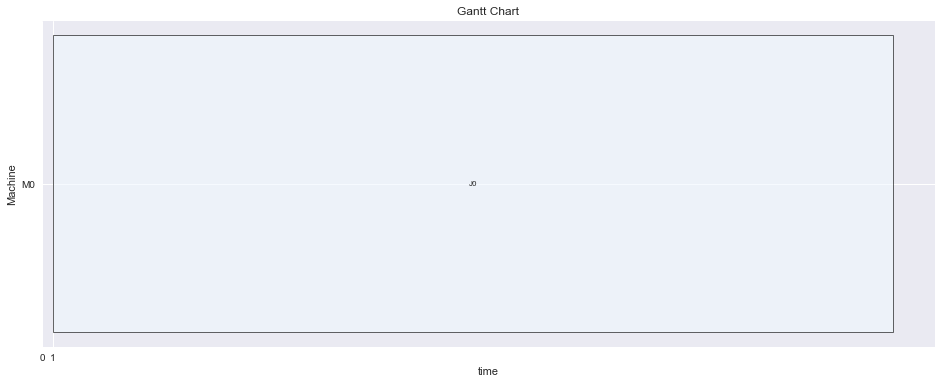

3 : product 1 ,type5 arrive
3 : product 1 ,type5 start treating at processor1


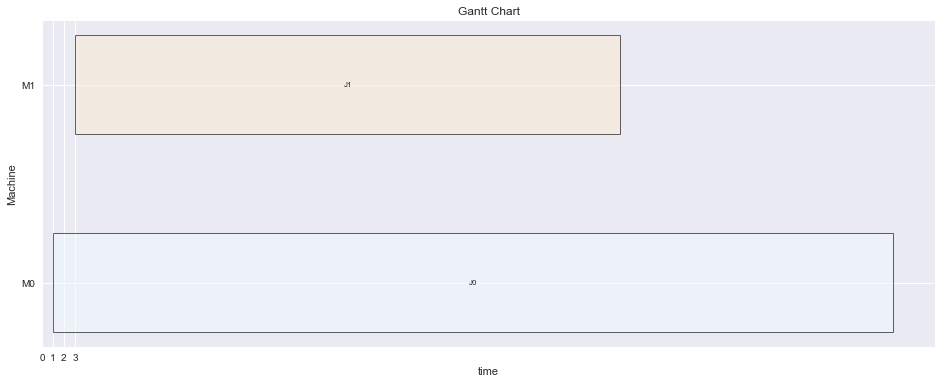

10 : product 2 ,type6 arrive
10 : product 2 ,type6 start treating at processor2


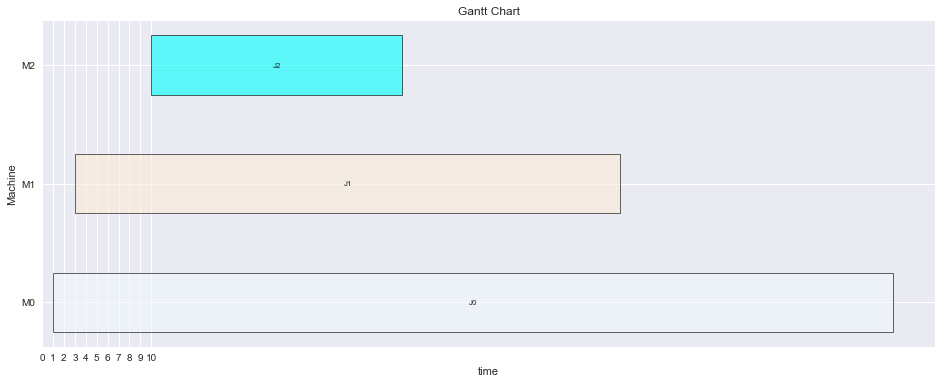

12 : product 3 ,type13 arrive
12 : product 3 ,type13 start treating at processor3


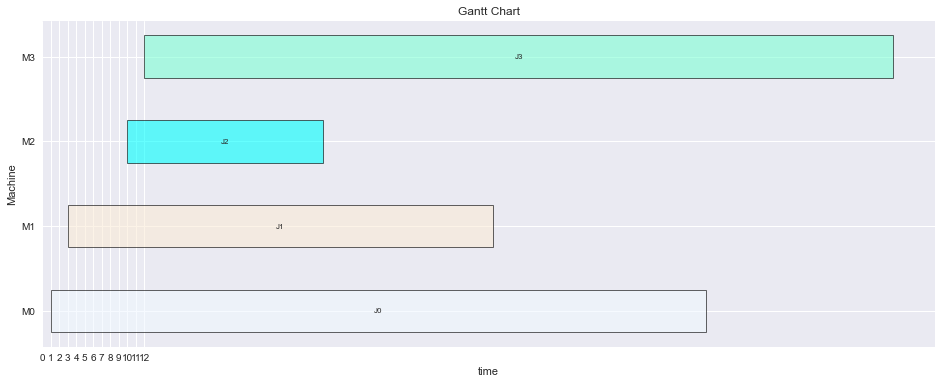

13 : product 4 ,type1 arrive
14 : product 5 ,type4 arrive
14 : product 6 ,type12 arrive
17 : product 7 ,type7 arrive
17 : product 8 ,type14 arrive
19 : product 9 ,type8 arrive
22 : product 10 ,type11 arrive
24 : product 11 ,type3 arrive
27 : product 12 ,type15 arrive
33 : product 2 ,type6 finish treating at processor2
33 : product 13 ,type10 arrive
Time:33, action:5
33 : product 11 ,type3 start treating at processor2


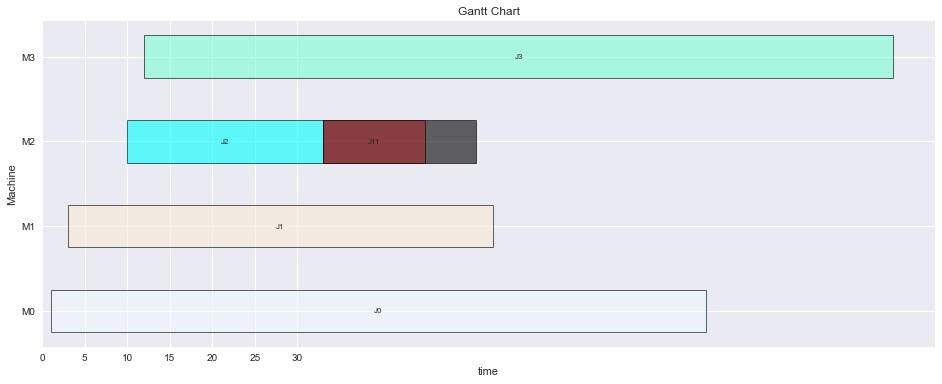

35 : product 14 ,type2 arrive
53 : product 1 ,type5 finish treating at processor1
Time:53, action:5
53 : product 14 ,type2 start treating at processor1


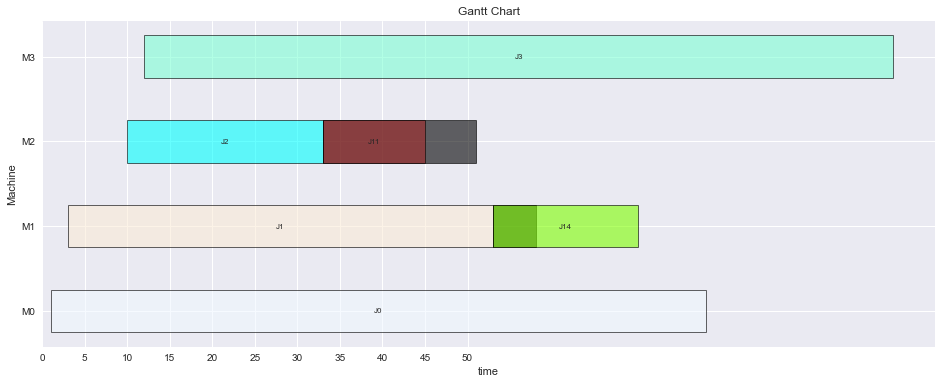

63 : product 11 ,type3 finish treating at processor2
Time:63, action:5
63 : product 7 ,type7 start treating at processor2


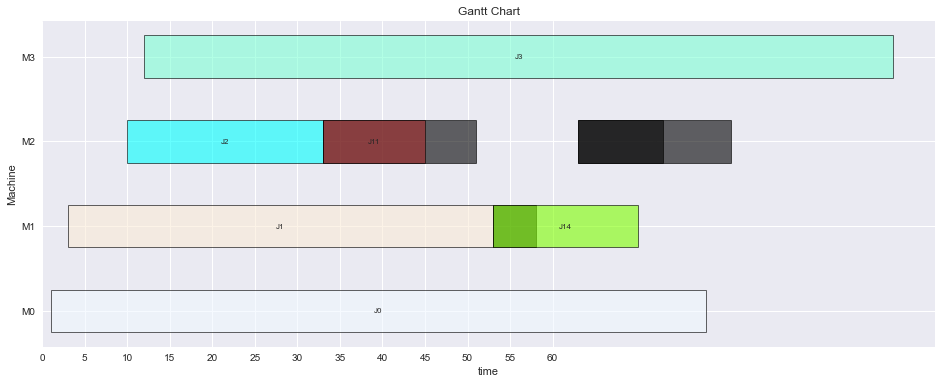

75 : product 14 ,type2 finish treating at processor1
Time:75, action:5
75 : product 6 ,type12 start treating at processor1


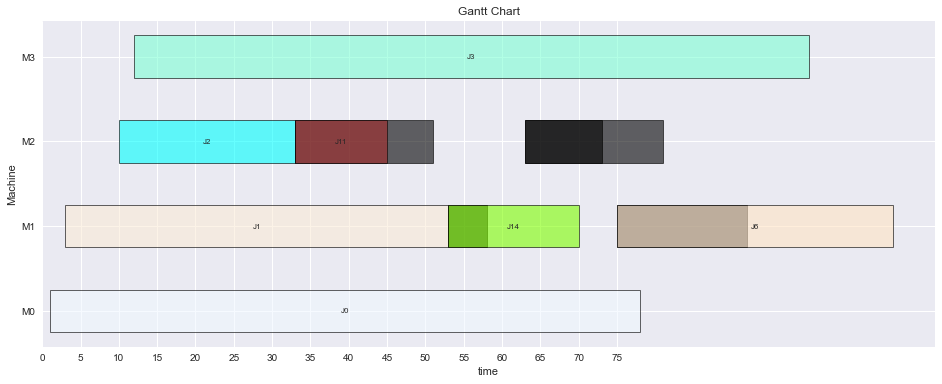

78 : product 0 ,type9 finish treating at processor0
Time:78, action:5
78 : product 12 ,type15 start treating at processor0


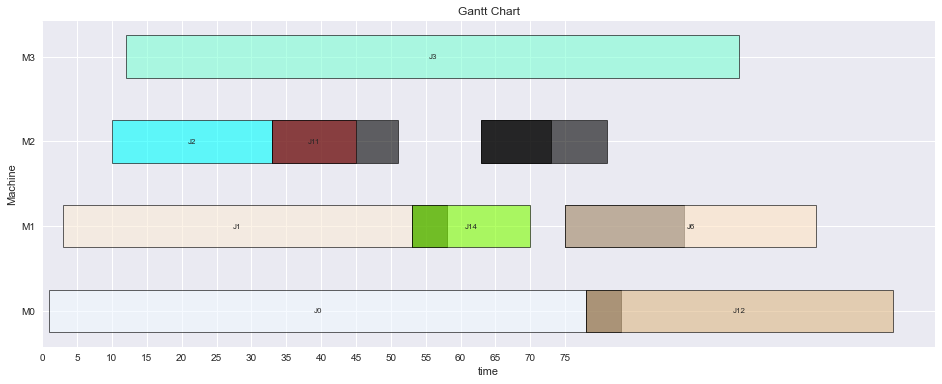

91 : product 7 ,type7 finish treating at processor2
Time:91, action:5
91 : product 10 ,type11 start treating at processor2


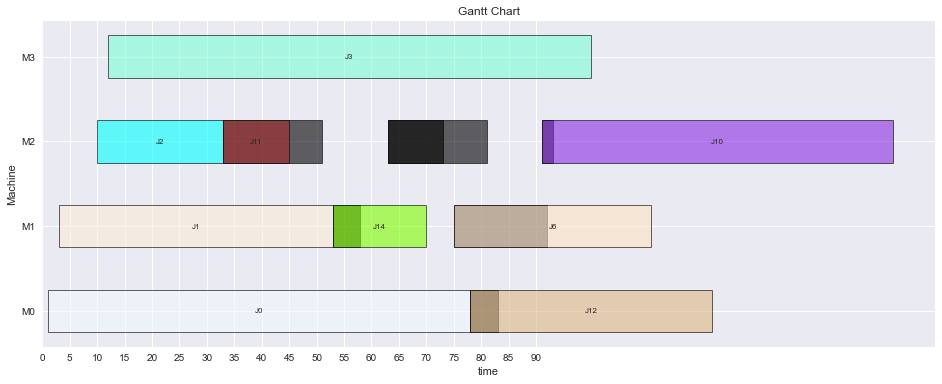

100 : product 3 ,type13 finish treating at processor3
Time:100, action:5
100 : product 9 ,type8 start treating at processor3


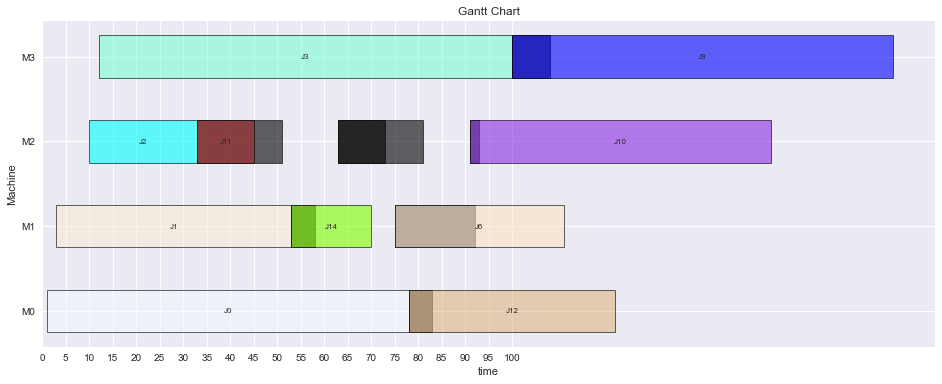

127 : product 12 ,type15 finish treating at processor0
Time:127, action:5
127 : product 8 ,type14 start treating at processor0


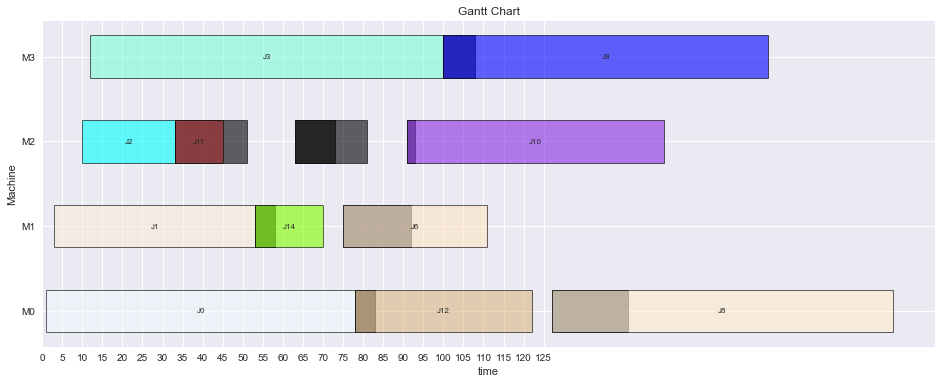

128 : product 6 ,type12 finish treating at processor1
Time:128, action:5
128 : product 5 ,type4 start treating at processor1


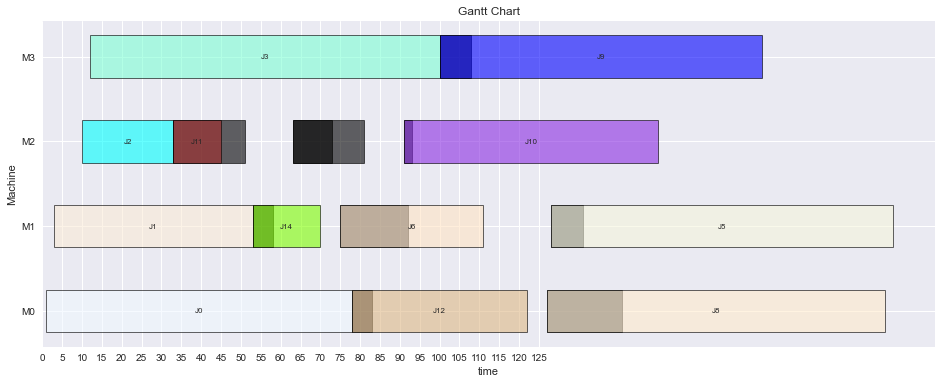

157 : product 10 ,type11 finish treating at processor2
Time:157, action:5
157 : product 4 ,type1 start treating at processor2


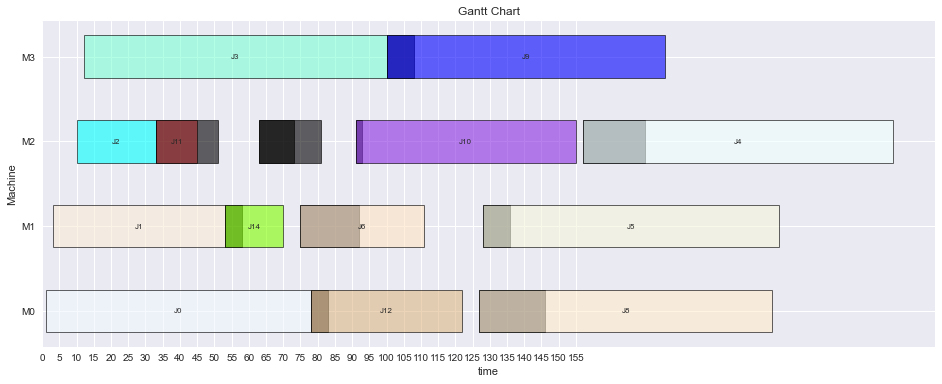

189 : product 9 ,type8 finish treating at processor3
Time:189, action:5
189 : product 13 ,type10 start treating at processor3


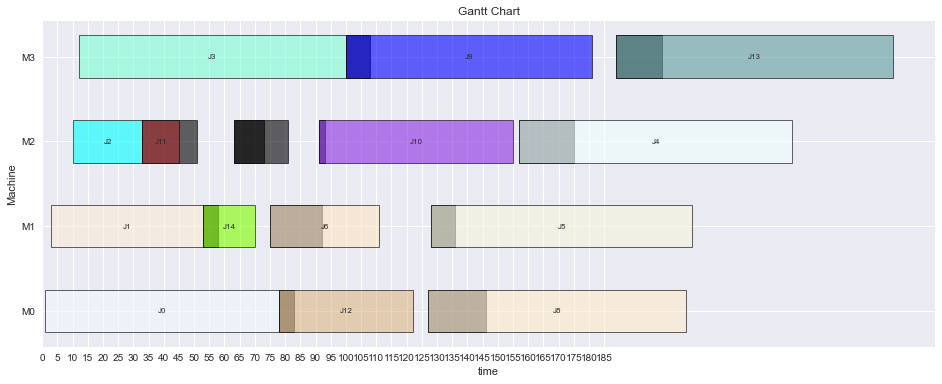

222 : product 5 ,type4 finish treating at processor1
231 : product 8 ,type14 finish treating at processor0
265 : product 4 ,type1 finish treating at processor2
295 : product 13 ,type10 finish treating at processor3
Number of late submissions: 6.0


In [6]:
env = Factory()
state = env.reset()
while True:
    action = 5
    print('Time:{}, action:{}'.format(env.env.now, action))
    next_state, reward, done, info = env.step(action)
    #print('Time:{}, state:{}, action:{}, reward:{}'.format(env.env.now, state, action, reward))
    state = next_state
    if done:
        print('Number of late submissions:',sum(info))
        break
